### Mateo Tejera - **`Segundo Trabajo Práctico`** - `Métodos Computacionales`

### `Parte 1: Descenso de Gradiente`

In [4]:
%load_ext autoreload
%autoreload 2

##### Imports

In [ ]:
import numpy as np
from tqdm.auto import tqdm

##### Constants

In [6]:
SEED = 42
healthy_path = "data/raw/Healthy"
parkinson_path = "data/raw/Parkinson"

##### Load Data

In [7]:
# Carga y División de Datos
from src.load_data import split_dataset 

X_train, y_train, X_test, y_test = split_dataset( 
    healthy_dir=healthy_path,
    parkinson_dir=parkinson_path,
    test_ratio=0.2,
    size=(64, 64),
    seed=SEED
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1304, 4096)
y_train shape: (1304,)
X_test shape: (328, 4096)
y_test shape: (328,)


##### `EJERCICIO 1 DERIVADAS`

In [53]:
# Función de activación
def f_wb(x, w, b):
    return (np.tanh(np.dot(x, w) + b) + 1) / 2

# Derivadas parciales de la función de pérdida L respecto a w y b
def derivadas_parciales_gd(X, y, w, b):
    t = np.tanh(np.dot(X, w) + b)            # activación
    f = f_wb(X, w, b)                        # activación con tanh normalizada

    error = f - y                           # diferencia entre predicción y verdadero

    # derivadas con regla de la cadena (tanh') = 1 - tanh²
    # y sabiendo que la loss es L(w, b) = MSE = 1/N ∑(fi - yi)², entonces:
    # 2/N (fi - yi) * dfi/dw o dfi/db
    df_dw = 2 * np.dot((error * 0.5*((1 - t**2))), X) / len(X)
    df_db = 2 * np.sum((error * 0.5*((1 - t**2)))) / len(X)

    return df_dw, df_db

##### `EJERCICIO 2 DESCENSO POR GRADIENTE`

In [ ]:
from src.metrics import accuracy 

In [ ]:
def gradient_descent_train(X_train, y_train, seed=SEED, alpha=1e-3, max_epochs=1000, verbose=True):
    np.random.seed(seed)
    w = np.random.randn(X_train.shape[1]) * 0.01 
    b = 0.0
    loss_history = []

    for epoch in tqdm(range(1, max_epochs+1), desc="GD training", dynamic_ncols=True):
        # Forward + pérdida
        f_pred = f_wb(X_train, w, b)                
        loss   = np.mean((f_pred - y_train)**2)     
        loss_history.append(loss)

        grad_w, grad_b = derivadas_parciales_gd(X_train, y_train, w, b)

        # Paso de descenso
        w -= alpha * grad_w
        b -= alpha * grad_b

        if verbose and (epoch == 1 or epoch % (max_epochs // 10) == 0):
            tqdm.write(f"Epoch {epoch:4d} | train loss={loss:.6f}")

    return w, b, loss_history

##### `EJERCICIO 3`

In [ ]:
def evaluate_model_gd(X, y, w, b):
    f =  f_wb(X, w, b)
    mse = np.mean((f - y)**2)
    acc = accuracy(y, f) 
    return mse, acc

In [ ]:
def gradient_descent_eval(X_train, y_train, X_test=None,  y_test=None, seed= SEED, alpha=0.001, verbose= True, max_epochs=10000):
    np.random.seed(seed)
    w = np.random.randn(X_train.shape[1]) * 0.01 
    b = 0.0

    loss_history_train = []
    acc_history_train  = []
    loss_history_test  = []
    acc_history_test   = []

    for epoch in tqdm(range(1, max_epochs+1), desc="Training", dynamic_ncols=True):
        # ==== train step ====
        f_train = f_wb(X_train, w, b)
        loss_t  = np.mean((f_train - y_train)**2)
        acc_t   = accuracy(f_train, y_train)
        loss_history_train.append(loss_t)
        acc_history_train.append(acc_t)

        # gradiente y actualización
        grad_w, grad_b = derivadas_parciales_gd(X_train, y_train, w, b)
        w -= alpha * grad_w
        b -= alpha * grad_b

        # ==== test evaluation ====
        if X_test is not None and y_test is not None:
            f_test = f_wb(X_test, w, b)
            loss_te  = np.mean((f_test - y_test)**2)
            acc_te   = accuracy(f_test, y_test)
            loss_history_test.append(loss_te)
            acc_history_test.append(acc_te)

        if verbose and epoch == 1 or epoch % (max_epochs/50) == 0:
            msg = f"Epoch {epoch:4d} | Train loss={loss_t:.4f}, acc={acc_t:.4f}"
            if loss_history_test:
                msg += f" | Test loss={loss_te:.4f}, acc={acc_te:.4f}"
            tqdm.write(msg)

    return w, b, loss_history_train, acc_history_train, loss_history_test, acc_history_test

In [ ]:
w_gd, b_gd, loss_hist_train_gd, acc_hist_train_gd, loss_hist_test_gd, acc_hist_test_gd = gradient_descent_eval(X_train, y_train, X_test, y_test, alpha=0.01, max_epochs=1000)

mse_train_gd, acc_train_gd = evaluate_model_gd(X_train, y_train, w_gd, b_gd)
mse_test_gd, acc_test_gd = evaluate_model_gd(X_test, y_test, w_gd, b_gd)

print(f"Train MSE: {mse_train_gd:.4f} | Accuracy: {acc_train_gd:.4f}")
print(f"Test  MSE: {mse_test_gd:.4f} | Accuracy: {acc_test_gd:.4f}")

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch   20 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch   40 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch   60 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch   80 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  100 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  120 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  140 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  160 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  180 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  200 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  220 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  240 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  260 | Train loss=0.5000, acc=0.

In [29]:
from src.plot import plot_loss

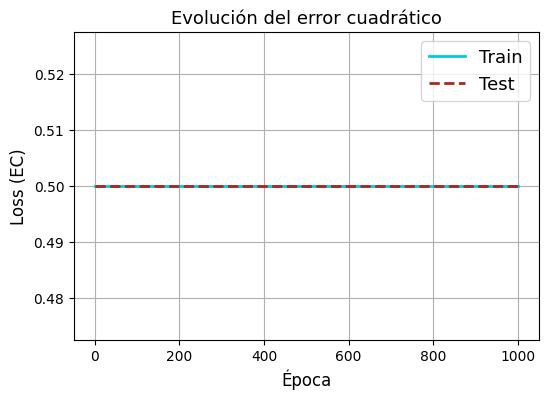

In [ ]:
# Graficar ambas curvas
plot_loss(loss_hist_train_gd, loss_hist_test_gd, 
          title="Evolución del error cuadarático para Gradient Descent: Train vs Test")

##### `EJERCICIO 4 NORMALIZACIÓN`

In [ ]:
from src.load_data import normalizar_dataset

In [71]:
X_train_n = normalizar_dataset(X_train)
X_test_n = normalizar_dataset(X_test)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.3146, acc=0.5000 | Test loss=0.3044, acc=0.5000
Epoch   20 | Train loss=0.2511, acc=0.4962 | Test loss=0.2515, acc=0.4726
Epoch   40 | Train loss=0.2506, acc=0.4962 | Test loss=0.2512, acc=0.4634
Epoch   60 | Train loss=0.2506, acc=0.4946 | Test loss=0.2511, acc=0.4665
Epoch   80 | Train loss=0.2506, acc=0.4939 | Test loss=0.2511, acc=0.4665
Epoch  100 | Train loss=0.2506, acc=0.4946 | Test loss=0.2511, acc=0.4665
Epoch  120 | Train loss=0.2506, acc=0.4954 | Test loss=0.2511, acc=0.4665
Epoch  140 | Train loss=0.2505, acc=0.4954 | Test loss=0.2511, acc=0.4665
Epoch  160 | Train loss=0.2505, acc=0.4946 | Test loss=0.2511, acc=0.4665
Epoch  180 | Train loss=0.2505, acc=0.4962 | Test loss=0.2511, acc=0.4665
Epoch  200 | Train loss=0.2505, acc=0.4962 | Test loss=0.2511, acc=0.4665
Epoch  220 | Train loss=0.2505, acc=0.4977 | Test loss=0.2511, acc=0.4665
Epoch  240 | Train loss=0.2505, acc=0.4977 | Test loss=0.2510, acc=0.4695
Epoch  260 | Train loss=0.2505, acc=0.

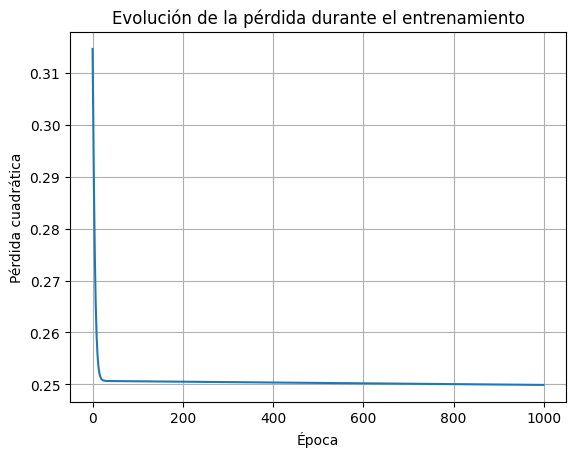

In [ ]:
# Entrenar modelo con datos normalizados
w_n_gd, b_n_gd, loss_hist_train_n_gd, acc_hist_train_n_gd, loss_history_test_n_gd, acc_history_test_n_gd = gradient_descent_eval(X_train_n, y_train, X_test_n, y_test, alpha=0.0001, max_epochs=1000)

mse_train_n_gd, acc_train_n_gd = evaluate_model_gd(X_train_n, y_train, w_n_gd, b_n_gd)
mse_test_n_gd, acc_test_n_gd = evaluate_model_gd(X_test_n, y_test, w_n_gd, b_n_gd)

print(f"[Normalizado] Train MSE: {mse_train_n_gd:.4f} | Accuracy: {acc_train_n_gd:.4f}")
print(f"[Normalizado] Test  MSE: {mse_test_n_gd:.4f} | Accuracy: {acc_test_n_gd:.4f}")


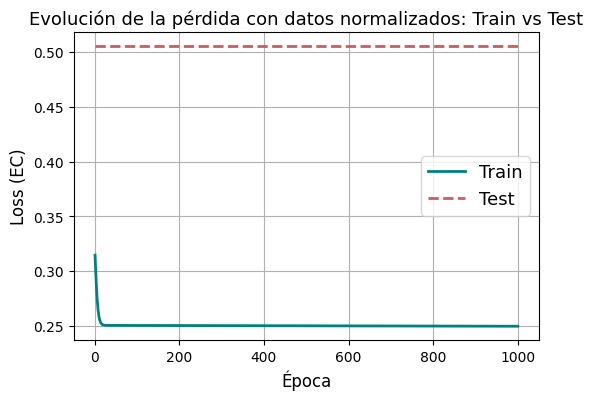

In [ ]:
plot_loss(loss_hist_train_n_gd, loss_history_test_n_gd, title = "Evolución de la pérdida con datos normalizados\npara Gradient Descent: Train vs Test")

##### `EJERCICIO 5 IMPACTO DEL PARÁMETRO α EN LA CONVERGENCIA DEL MÉTODO`

In [ ]:
# Lista de alphas a probar
best_alphas = [0.0001, 0.001, 0.01, 0.05, 0.1]

results_alpha_sweep_gd = {}
for alpha in tqdm(best_alphas, desc="Alphas"):

    w_gd_i, b_gd_i, loss_hist_train_gd_i, acc_hist_train_gd_i, loss_hist_test_gd_i, acc_hist_test_gd_i = gradient_descent_eval(X_train_n, y_train, X_test_n, y_test, alpha=alpha, max_epochs=10000)
    mse_test_gd_i, acc_test_gd_i = evaluate_model_gd(X_test_n, y_test, w_gd_i, b_gd_i)
    mse_train_gd_i, acc_train_gd_i = evaluate_model_gd(X_train_n, y_train, w_gd_i, b_gd_i)

    results_alpha_sweep_gd[alpha] = {
        'mse_test': mse_test_gd_i,
        'mse_train': mse_train_gd_i,
        'acc_train_final': acc_train_gd_i,
        'acc_test_final': acc_test_gd_i,
        'acc_train': acc_hist_train_gd_i,
        'acc_test': acc_hist_test_gd_i,
        'loss_train': loss_hist_train_gd_i,
        'loss_test': loss_hist_test_gd_i,
    }
    
    print(f"α = {alpha:.4f} → "
        f"Test MSE = {mse_test_gd_i:.4f} | Acc Test = {acc_test_gd_i:.4f} | "
        f"Train MSE = {mse_train_gd_i:.4f} | Acc Train = {acc_train_gd_i:.4f}")

Alphas:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.3146, acc=0.5000 | Test loss=0.3044, acc=0.5000
Epoch  200 | Train loss=0.2505, acc=0.4962 | Test loss=0.2511, acc=0.4665
Epoch  400 | Train loss=0.2503, acc=0.5069 | Test loss=0.2509, acc=0.4695
Epoch  600 | Train loss=0.2502, acc=0.5123 | Test loss=0.2508, acc=0.4726
Epoch  800 | Train loss=0.2500, acc=0.5169 | Test loss=0.2507, acc=0.4817
Epoch 1000 | Train loss=0.2499, acc=0.5238 | Test loss=0.2506, acc=0.4817
Epoch 1200 | Train loss=0.2497, acc=0.5284 | Test loss=0.2505, acc=0.4848
Epoch 1400 | Train loss=0.2496, acc=0.5330 | Test loss=0.2504, acc=0.4878
Epoch 1600 | Train loss=0.2494, acc=0.5376 | Test loss=0.2503, acc=0.4939
Epoch 1800 | Train loss=0.2493, acc=0.5414 | Test loss=0.2502, acc=0.5000
Epoch 2000 | Train loss=0.2491, acc=0.5445 | Test loss=0.2501, acc=0.5000
Epoch 2200 | Train loss=0.2490, acc=0.5491 | Test loss=0.2499, acc=0.5061
Epoch 2400 | Train loss=0.2488, acc=0.5529 | Test loss=0.2498, acc=0.5122
Epoch 2600 | Train loss=0.2487, acc=0.

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.3146, acc=0.5000 | Test loss=0.2516, acc=0.4817
Epoch  200 | Train loss=0.2491, acc=0.5445 | Test loss=0.2501, acc=0.5000
Epoch  400 | Train loss=0.2476, acc=0.5836 | Test loss=0.2490, acc=0.5335
Epoch  600 | Train loss=0.2461, acc=0.6112 | Test loss=0.2479, acc=0.5610
Epoch  800 | Train loss=0.2447, acc=0.6388 | Test loss=0.2468, acc=0.5915
Epoch 1000 | Train loss=0.2432, acc=0.6656 | Test loss=0.2458, acc=0.6250
Epoch 1200 | Train loss=0.2418, acc=0.6863 | Test loss=0.2448, acc=0.6433
Epoch 1400 | Train loss=0.2405, acc=0.7063 | Test loss=0.2438, acc=0.6555
Epoch 1600 | Train loss=0.2391, acc=0.7209 | Test loss=0.2428, acc=0.6494
Epoch 1800 | Train loss=0.2378, acc=0.7377 | Test loss=0.2418, acc=0.6677
Epoch 2000 | Train loss=0.2365, acc=0.7423 | Test loss=0.2409, acc=0.6768
Epoch 2200 | Train loss=0.2352, acc=0.7439 | Test loss=0.2400, acc=0.6921
Epoch 2400 | Train loss=0.2340, acc=0.7515 | Test loss=0.2391, acc=0.6951
Epoch 2600 | Train loss=0.2328, acc=0.

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.3146, acc=0.5000 | Test loss=0.4998, acc=0.5000
Epoch  200 | Train loss=0.4998, acc=0.5000 | Test loss=0.4998, acc=0.5000
Epoch  400 | Train loss=0.4995, acc=0.5000 | Test loss=0.4995, acc=0.5000
Epoch  600 | Train loss=0.4981, acc=0.5000 | Test loss=0.4976, acc=0.5000
Epoch  800 | Train loss=0.4952, acc=0.5000 | Test loss=0.4920, acc=0.5000
Epoch 1000 | Train loss=0.4994, acc=0.5000 | Test loss=0.4994, acc=0.5000
Epoch 1200 | Train loss=0.4981, acc=0.5000 | Test loss=0.4976, acc=0.5000
Epoch 1400 | Train loss=0.4994, acc=0.5000 | Test loss=0.4993, acc=0.5000
Epoch 1600 | Train loss=0.4988, acc=0.5000 | Test loss=0.4986, acc=0.5000
Epoch 1800 | Train loss=0.4969, acc=0.5000 | Test loss=0.4955, acc=0.5000
Epoch 2000 | Train loss=0.4998, acc=0.5000 | Test loss=0.4997, acc=0.5000
Epoch 2200 | Train loss=0.4996, acc=0.5000 | Test loss=0.4996, acc=0.5000
Epoch 2400 | Train loss=0.4999, acc=0.5000 | Test loss=0.4998, acc=0.5000
Epoch 2600 | Train loss=0.4976, acc=0.

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.3146, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  200 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  400 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  600 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  800 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 1000 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 1200 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 1400 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 1600 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 1800 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 2000 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 2200 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 2400 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 2600 | Train loss=0.5000, acc=0.

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.3146, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  200 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  400 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  600 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch  800 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 1000 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 1200 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 1400 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 1600 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 1800 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 2000 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 2200 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 2400 | Train loss=0.5000, acc=0.5000 | Test loss=0.5000, acc=0.5000
Epoch 2600 | Train loss=0.5000, acc=0.

In [ ]:
from src.plot import plot_metrics_by_alpha

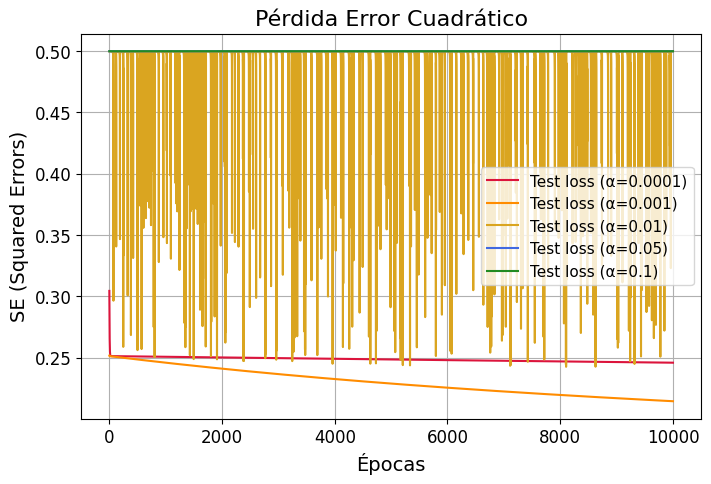

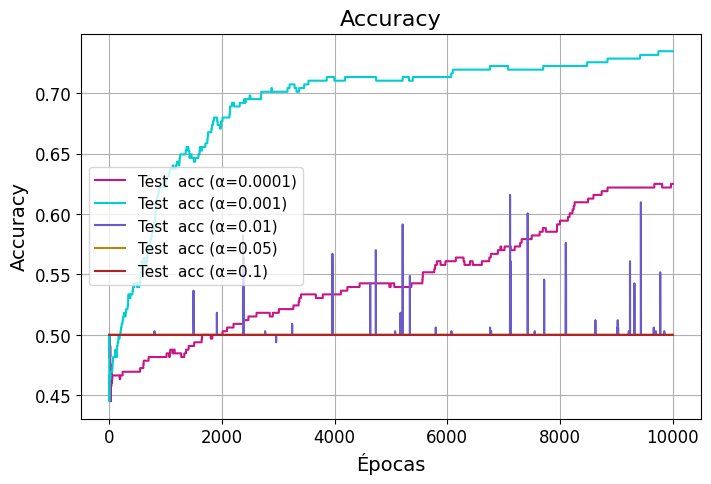

In [ ]:
plot_metrics_by_alpha(results_alpha_sweep_gd)

Me defino el mejor alpha

In [38]:
best_alpha = 0.001

##### `EJERCICIO 6 IMPACTO DEL TAMAÑO DEL ESCALADO`

In [43]:
X_train_32, y_train_32, X_test_32, y_test_32 = split_dataset(
    healthy_dir=healthy_path,
    parkinson_dir=parkinson_path,
    test_ratio=0.2,
    size=(32, 32)
)

X_train_32_n = normalizar_dataset(X_train_32)
X_test_32_n = normalizar_dataset(X_test_32)

X_train_128, y_train_128, X_test_128, y_test_128 = split_dataset(
    healthy_dir=healthy_path,
    parkinson_dir=parkinson_path,
    test_ratio=0.2,
    size=(128, 128)
)

X_train_128_n = normalizar_dataset(X_train_128)
X_test_128_n = normalizar_dataset(X_test_128)

In [44]:
scales = {
    32: {
        "Train": (X_train_32_n, y_train_32),
        "Test":  (X_test_32_n,  y_test_32)
    },
    64: {
        "Train": (X_train_n, y_train),
        "Test":  (X_test_n,  y_test)
    },
    128: {
        "Train": (X_train_128_n, y_train_128),
        "Test":  (X_test_128_n,  y_test_128)
    }
}

In [ ]:
results_scales_sweep_gd = {}

for size, datasets in tqdm(
    scales.items(),
    desc="Tamaños",
    dynamic_ncols=True,
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{remaining} restantes]'
):
    X_train, y_train = datasets["Train"]
    X_test,  y_test  = datasets["Test"]

    w_gd_i, b_gd_i, loss_hist_train_gd_i, acc_hist_train_gd_i, loss_hist_test_gd_i, acc_hist_test_gd_i = gradient_descent_eval(
        X_train, y_train, X_test, y_test, alpha=best_alpha, max_epochs=10000
    )

    mse_test_gd_i, acc_test_gd_i = evaluate_model_gd(X_test, y_test, w_gd_i, b_gd_i)
    mse_train_gd_i, acc_train_gd_i = evaluate_model_gd(X_train, y_train, w_gd_i, b_gd_i)

    results_scales_sweep_gd[size] = {
        'mse_test': mse_test_gd_i,
        'mse_train': mse_train_gd_i,
        'acc_train_final': acc_train_gd_i,
        'acc_test_final': acc_test_gd_i,
        'acc_train': acc_hist_train_gd_i,
        'acc_test': acc_hist_test_gd_i,
        'loss_train': loss_hist_train_gd_i,
        'loss_test': loss_hist_test_gd_i,
    }

    print(f"Size = {size:>3} → "
          f"Test MSE = {mse_test_gd_i:.4f} | Acc Test = {acc_test_gd_i:.4f} | "
          f"Train MSE = {mse_train_gd_i:.4f} | Acc Train = {acc_train_gd_i:.4f}")

Tamaños:   0%|          | 0/3 [? restantes]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.2649, acc=0.5000 | Test loss=0.2583, acc=0.5000
Epoch  100 | Train loss=0.2499, acc=0.5061 | Test loss=0.2504, acc=0.4726
Epoch  200 | Train loss=0.2497, acc=0.5169 | Test loss=0.2504, acc=0.4726
Epoch  300 | Train loss=0.2496, acc=0.5184 | Test loss=0.2503, acc=0.4848
Epoch  400 | Train loss=0.2494, acc=0.5322 | Test loss=0.2502, acc=0.4848
Epoch  500 | Train loss=0.2493, acc=0.5452 | Test loss=0.2501, acc=0.4726
Epoch  600 | Train loss=0.2492, acc=0.5529 | Test loss=0.2501, acc=0.4756
Epoch  700 | Train loss=0.2490, acc=0.5552 | Test loss=0.2500, acc=0.4909
Epoch  800 | Train loss=0.2489, acc=0.5544 | Test loss=0.2499, acc=0.4939
Epoch  900 | Train loss=0.2488, acc=0.5544 | Test loss=0.2498, acc=0.4939
Epoch 1000 | Train loss=0.2487, acc=0.5567 | Test loss=0.2498, acc=0.5061
Epoch 1100 | Train loss=0.2485, acc=0.5644 | Test loss=0.2497, acc=0.5091
Epoch 1200 | Train loss=0.2484, acc=0.5660 | Test loss=0.2496, acc=0.5122
Epoch 1300 | Train loss=0.2483, acc=0.

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.3142, acc=0.5000 | Test loss=0.2510, acc=0.4970
Epoch  100 | Train loss=0.2500, acc=0.5115 | Test loss=0.2500, acc=0.4878
Epoch  200 | Train loss=0.2492, acc=0.5383 | Test loss=0.2496, acc=0.5091
Epoch  300 | Train loss=0.2484, acc=0.5521 | Test loss=0.2492, acc=0.5244
Epoch  400 | Train loss=0.2477, acc=0.5706 | Test loss=0.2487, acc=0.5244
Epoch  500 | Train loss=0.2469, acc=0.5775 | Test loss=0.2483, acc=0.5213
Epoch  600 | Train loss=0.2462, acc=0.5928 | Test loss=0.2478, acc=0.5335
Epoch  700 | Train loss=0.2454, acc=0.6028 | Test loss=0.2473, acc=0.5427
Epoch  800 | Train loss=0.2447, acc=0.6127 | Test loss=0.2469, acc=0.5457
Epoch  900 | Train loss=0.2440, acc=0.6219 | Test loss=0.2464, acc=0.5579
Epoch 1000 | Train loss=0.2433, acc=0.6281 | Test loss=0.2459, acc=0.5701
Epoch 1100 | Train loss=0.2426, acc=0.6350 | Test loss=0.2455, acc=0.5793
Epoch 1200 | Train loss=0.2419, acc=0.6472 | Test loss=0.2450, acc=0.5915
Epoch 1300 | Train loss=0.2412, acc=0.

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.2559, acc=0.5077 | Test loss=0.3112, acc=0.5000
Epoch  100 | Train loss=0.3654, acc=0.5000 | Test loss=0.3998, acc=0.5000
Epoch  200 | Train loss=0.4085, acc=0.5000 | Test loss=0.3054, acc=0.5000
Epoch  300 | Train loss=0.2481, acc=0.5613 | Test loss=0.2969, acc=0.5030
Epoch  400 | Train loss=0.2713, acc=0.5054 | Test loss=0.4313, acc=0.5000
Epoch  500 | Train loss=0.2891, acc=0.5008 | Test loss=0.4508, acc=0.5000
Epoch  600 | Train loss=0.4487, acc=0.5000 | Test loss=0.3153, acc=0.5000
Epoch  700 | Train loss=0.4475, acc=0.5000 | Test loss=0.3105, acc=0.5000
Epoch  800 | Train loss=0.4242, acc=0.5000 | Test loss=0.2541, acc=0.5488
Epoch  900 | Train loss=0.3006, acc=0.5008 | Test loss=0.4497, acc=0.5000
Epoch 1000 | Train loss=0.2749, acc=0.5084 | Test loss=0.4456, acc=0.5000
Epoch 1100 | Train loss=0.4484, acc=0.5000 | Test loss=0.2905, acc=0.5030
Epoch 1200 | Train loss=0.4435, acc=0.5000 | Test loss=0.2943, acc=0.5000
Epoch 1300 | Train loss=0.4479, acc=0.

KeyboardInterrupt: 

In [ ]:
from src.plot import plot_metrics_by_size

In [ ]:
plot_metrics_by_size(results_scales_sweep_gd)

##### `EJERCICIO 7`

##### Entrenamiento final con el mejor alpha=0.001 y tamaño de escalado= 64x64

In [ ]:
resultados_finales_gd = {}

w_final_gd, b_final_gd, loss_hist_train_final_gd, acc_hist_train_final_gd, loss_hist_test_final_gd, acc_hist_test_final_gd = gradient_descent_eval(X_train_n, y_train, X_test_n, y_test, alpha=best_alpha, max_epochs=130000)
mse_test_final_gd, acc_test_final_gd = evaluate_model_gd(X_test_n, y_test, w_final_gd, b_final_gd)
mse_train_final_gd, acc_train_final_gd = evaluate_model_gd(X_train_n, y_train, w_final_gd, b_final_gd)

resultados_finales_gd[alpha] = {
    'mse_test': mse_test_final_gd,
    'mse_train': mse_train_final_gd,
    'acc_train_final': acc_train_final_gd,
    'acc_test_final': acc_test_final_gd,
    'acc_train': acc_hist_train_final_gd,
    'acc_test': acc_hist_test_final_gd,
    'loss_train': loss_hist_train_final_gd,
    'loss_test': loss_hist_test_final_gd,
}

print(f"Test MSE = {mse_test_final_gd:.4f} | Acc Test = {acc_test_final_gd:.4f} | "
      f"Train MSE = {mse_train_final_gd:.4f} | Acc Train = {acc_train_final_gd:.4f}")

GD training:   0%|          | 0/130000 [00:00<?, ?it/s]

Epoch    1 | train loss=0.281593, acc=0.5000 | test loss=0.500000, acc=0.5000
Epoch 13000 | train loss=0.481595, acc=0.5184 | test loss=0.493902, acc=0.5061
Epoch 26000 | train loss=0.368098, acc=0.6319 | test loss=0.420732, acc=0.5793
Epoch 39000 | train loss=0.288222, acc=0.7117 | test loss=0.362805, acc=0.6372
Epoch 52000 | train loss=0.098926, acc=0.9011 | test loss=0.158495, acc=0.8415
Epoch 65000 | train loss=0.053604, acc=0.9463 | test loss=0.125816, acc=0.8720
Epoch 78000 | train loss=0.038188, acc=0.9617 | test loss=0.126969, acc=0.8720
Epoch 91000 | train loss=0.016875, acc=0.9831 | test loss=0.115854, acc=0.8841
Epoch 104000 | train loss=0.007766, acc=0.9923 | test loss=0.118903, acc=0.8811
Epoch 117000 | train loss=0.009168, acc=0.9908 | test loss=0.097561, acc=0.9024
Epoch 130000 | train loss=0.008333, acc=0.9908 | test loss=0.106711, acc=0.8933
Test MSE = 0.1067 | Acc Test = 0.8933 | Train MSE = 0.0514 | Acc Train = 0.9486


In [ ]:
plot_metrics_by_alpha(resultados_finales_gd, plot_train = True, title1="Pérdida Error Cuadrático: Train vs Test", title2="Accuracy: Train vs Test")

##### `Matriz de confusión`

In [ ]:
from src.metrics import confusion_matrix
from src.plot import plot_confusion_matrix

In [ ]:
def predecir_gd(X, w, b):
    fx = f_wb(X, w, b)
    return (fx >= 0.5).astype(int)

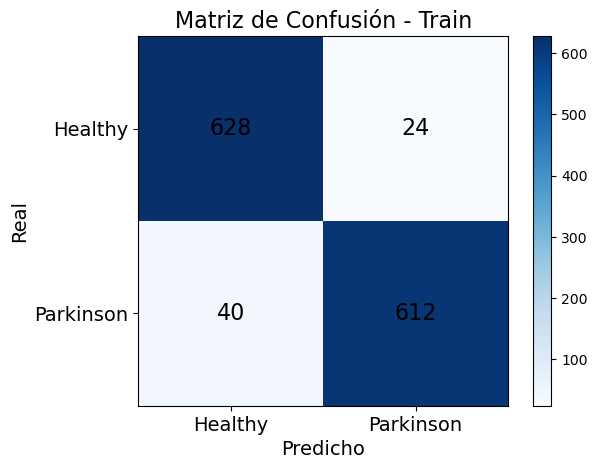

In [ ]:
y_pred_train_gd = predecir_gd(X_train_n, w_final_gd, b_final_gd)
cm_train_gd = confusion_matrix(y_train, y_pred_train_gd)

plot_confusion_matrix(cm_train_gd , titulo="Matriz de Confusión GD - Train")

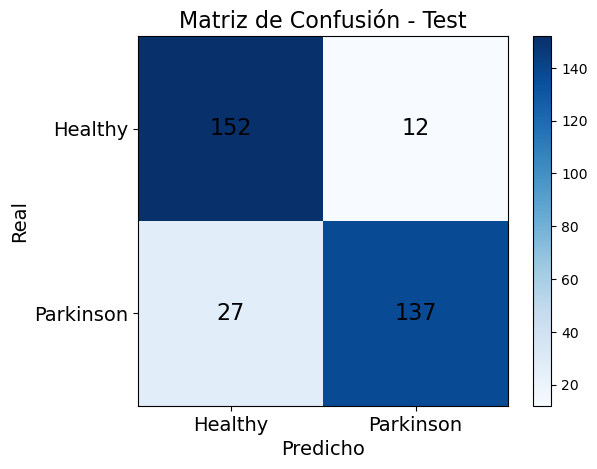

In [ ]:
y_pred_test_gd = predecir_gd(X_test_n, w_final_gd, b_final_gd)
cm_test_gd = confusion_matrix(y_test, y_pred_test_gd)

plot_confusion_matrix(cm_test_gd, titulo="Matriz de Confusión GD - Test")

### `Parte 2: Ascenso de Gradiente`

##### `EJERCICIO 1 DERIVADAS`

In [ ]:
import cupy as cp 
from tqdm.auto import tqdm

In [102]:
# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))

# def derivadas_parciales_ga(w, b, X, y):
#     z = np.dot(X, w) + b          
#     y_pred = sigmoid(z)          
#     error = y - y_pred          

#     df_dw = np.dot(X.T, error) 
#     df_db = np.sum(error)  

#     return df_dw, df_db
 
def sigmoid(z):
    return 1 / (1 + cp.exp(-z)) 

def derivadas_parciales_ga(w, b, X, y):
    z      = cp.dot(X, w) + b
    y_pred = sigmoid(z)
    error  = y - y_pred        
    df_dw  = cp.dot(X.T, error)
    df_db  = cp.sum(error)
    return df_dw, df_db

##### `EJERCICIO 2 ASCENSO POR GRADIENTE`

In [104]:
# # def log_verosimilitud(w, b, X, y):
# #     """
# #     L(w,b) = sum_i [ d_i*log(σ(z_i)) + (1-d_i)*log(1-σ(z_i)) ]
# #     """
# #     z      = np.dot(X, w) + b
# #     y_pred = sigmoid(z)
    
# #     eps = 1e-12     # para evitar log(0)
# #     return np.sum(y * np.log(y_pred  + eps) + (1-y) * np.log(1 - y_pred + eps))

# def average_log_loss(w, b, X, y):
#     """
#     Log-loss promedio: 
#       −(1/N) sum_i [ y_i log(σ(z_i)) + (1-y_i) log(1−σ(z_i)) ]
#     """
#     N      = X.shape[0]
#     z      = np.dot(X, w) + b
#     y_pred = sigmoid(z)
#     eps    = 1e-12
#     ll     = y * np.log(y_pred + eps) + (1-y) * np.log(1 - y_pred + eps)
#     return -np.mean(ll)



# def gradient_ascent_train(
#     X_train, y_train,
#     seed=SEED, alpha=0.001, max_epochs=1000, verbose=True
# ):

#     np.random.seed(seed)
#     N, D = X_train.shape

#     # Inicialización
#     w = np.random.randn(D) * 0.01
#     b = 0.0

#     loss_history = []
#     acc_history  = []

#     for epoch in tqdm(range(1, max_epochs+1), desc="GA training", dynamic_ncols=True):
#         # Cálculo de gradientes
#         df_dw, df_db = derivadas_parciales_ga(w, b, X_train, y_train)

#         # Paso de ascenso
#         w += alpha * df_dw
#         b += alpha * df_db

#         # Métricas
#         loss = average_log_loss(w, b, X_train, y_train)
#         y_pred = sigmoid(X_train.dot(w) + b)
#         acc  = accuracy(y_train, y_pred)

#         loss_history.append(loss)
#         acc_history.append(acc)

#         # Logging periódico
#         if verbose and (epoch == 1 or epoch % (max_epochs // 10) == 0):
#             print(f"Epoch {epoch:4d} | loss={loss:.4f}, acc={acc:.4f}")

#     return w, b, loss_history, acc_history

def gradient_ascent_train(X_train, y_train, seed=SEED, alpha=1e-3, max_epochs=1000, verbose=True):

    # Convertir a CuPy
    X = cp.array(X_train)
    y = cp.array(y_train)
    N, D = X.shape

    # Inicializar parámetros
    cp.random.seed(seed)
    w = cp.random.randn(D) * 0.01
    b = cp.array(0.0)
 
    loss_history = []
    acc_history  = []

    for epoch in tqdm(range(1, max_epochs+1), desc="GA training", dynamic_ncols=True):
        df_dw, df_db = derivadas_parciales_ga(w, b, X, y)

        # Actualización (ascenso)
        w += alpha * df_dw
        b += alpha * df_db

        # Métricas
        loss = average_log_loss(w, b, X, y)
        y_pred = sigmoid(cp.dot(X, w) + b)
        acc  = accuracy(y, y_pred)

        loss_history.append(cp.asnumpy(loss))
        acc_history.append(cp.asnumpy(acc))

        if verbose and (epoch == 1 or epoch % (max_epochs // 10) == 0):
            tqdm.write(f"Epoch {epoch:4d} | loss={float(loss):.4f}, acc={float(acc):.4f}")

    return cp.asnumpy(w), float(b), loss_history, acc_history


def accuracy(y_true, y_pred):
    return cp.mean((y_pred > 0.5) == (y_true > 0.5))

def average_log_loss(w, b, X, y):
    N      = X.shape[0]
    z      = cp.dot(X, w) + b
    y_pred = sigmoid(z)
    eps    = 1e-12
    ll     = y * cp.log(y_pred + eps) + (1 - y) * cp.log(1 - y_pred + eps)
    return -cp.mean(ll)


usamos la mejor escala encontrada en la parte 1: 64 x 64 con los datos normalizados

GA training:   0%|          | 0/50000 [00:00<?, ?it/s]

Epoch    1 | loss=13.8155, acc=0.5000
Epoch 5000 | loss=13.8155, acc=0.5000
Epoch 10000 | loss=13.6292, acc=0.5061
Epoch 15000 | loss=12.8715, acc=0.5307
Epoch 20000 | loss=11.4432, acc=0.5798
Epoch 25000 | loss=10.3010, acc=0.6173
Epoch 30000 | loss=9.4631, acc=0.6480
Epoch 35000 | loss=9.8414, acc=0.6350
Epoch 40000 | loss=8.0335, acc=0.7017
Epoch 45000 | loss=6.9261, acc=0.7339
Epoch 50000 | loss=7.4501, acc=0.7216


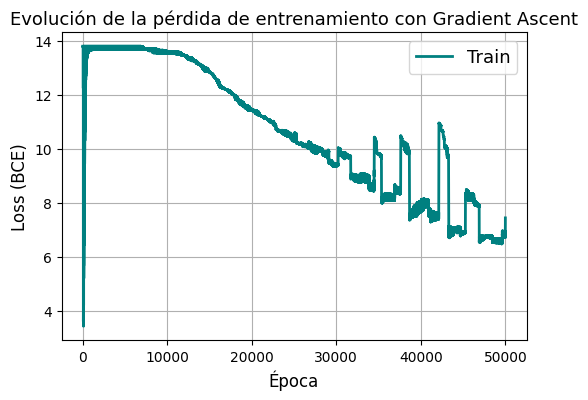

In [ ]:
w_ga, b_ga, loss_hist_ga, acc_hist_ga = gradient_ascent_train(X_train_n, y_train, alpha=0.001, max_epochs=50000, verbose=True)

plot_loss(loss_hist_ga, title="Evolución de la pérdida de entrenamiento con Gradient Ascent", gd= False, lw=1)

##### `EJERCICIO 3`

In [106]:
# def gradient_ascent_with_eval(X_train, y_train, X_test=None, y_test=None, seed=SEED, alpha=1e-3, max_epochs=1000, verbose=True):

#     np.random.seed(seed)
#     N, K   = X_train.shape
#     w      = np.random.randn(K) * 0.01
#     b      = 0.0

#     # Historiales
#     loss_hist_train = []
#     acc_hist_train  = []
#     loss_hist_test  = []
#     acc_hist_test   = []

#     for epoch in tqdm(range(1, max_epochs+1), desc="GA training", dynamic_ncols=True):
#         # Eval train
#         z_train   = np.dot(X_train, w) + b
#         y_pred_tr = sigmoid(z_train)
#         loss_tr   = average_log_loss(w, b, X_train, y_train)
#         acc_tr    = accuracy(y_train, y_pred_tr)

#         loss_hist_train.append(loss_tr)
#         acc_hist_train.append(acc_tr)

#         # Gradiente & actualización
#         grad_w, grad_b = derivadas_parciales_ga(w, b, X_train, y_train)
#         w += alpha * grad_w
#         b += alpha * grad_b

#         # Eval test
#         if X_test is not None and y_test is not None:
#             z_test   = np.dot(X_test, w) + b
#             y_pred_te = sigmoid(z_test)
#             loss_te   = average_log_loss(w, b, X_test, y_test)
#             acc_te    = accuracy(y_test, y_pred_te)

#             loss_hist_test.append(loss_te)
#             acc_hist_test.append(acc_te)

#         # Impresión periódica
#         if verbose and (epoch == 1 or epoch % (max_epochs // 10) == 0):
#             msg = (f"Epoch {epoch:4d} | "
#                    f"Train loss={loss_tr:.4f}, acc={acc_tr:.4f}")
#             if loss_hist_test:
#                 msg += f" | Test loss={loss_te:.4f}, acc={acc_te:.4f}"
#             tqdm.write(msg)

#     return (
#         w, b,
#         loss_hist_train, acc_hist_train,
#         loss_hist_test,  acc_hist_test
#     )

def gradient_ascent_with_eval(X_train, y_train, X_test=None, y_test=None,
                         seed=42, alpha=1e-3, max_epochs=1000, verbose=True):

    # ——— Convertir las entradas a CuPy ———
    X_train = cp.array(X_train)
    y_train = cp.array(y_train)
    if X_test is not None:
        X_test = cp.array(X_test)
        y_test = cp.array(y_test)
 
    # ——— Inicializaciones ———
    cp.random.seed(seed)
    N, K   = X_train.shape
    w      = cp.random.randn(K) * 0.01
    b      = cp.array(0.0)

    # Historiales
    loss_hist_train = []
    acc_hist_train  = []
    loss_hist_test  = []
    acc_hist_test   = []

    for epoch in tqdm(range(1, max_epochs+1), desc="GA training", dynamic_ncols=True):
        # ——— TRAIN ———
        z_train   = cp.dot(X_train, w) + b
        y_pred_tr = sigmoid(z_train)
        loss_tr   = average_log_loss(w, b, X_train, y_train)
        acc_tr    = accuracy(y_train, y_pred_tr)

        loss_hist_train.append(cp.asnumpy(loss_tr))
        acc_hist_train.append(cp.asnumpy(acc_tr))

        # ——— GRADIENT STEP ———
        grad_w, grad_b = derivadas_parciales_ga(w, b, X_train, y_train)
        w += alpha * grad_w
        b += alpha * grad_b

        # ——— TEST ———
        if X_test is not None:
            z_test    = cp.dot(X_test, w) + b
            y_pred_te = sigmoid(z_test)
            loss_te   = average_log_loss(w, b, X_test, y_test)
            acc_te    = accuracy(y_test, y_pred_te)

            loss_hist_test.append(cp.asnumpy(loss_te))
            acc_hist_test.append(cp.asnumpy(acc_te))

        # ——— LOG ———
        if verbose and (epoch == 1 or epoch % (max_epochs // 10) == 0):
            msg = f"Epoch {epoch:4d} | Train loss={float(loss_tr):.4f}, acc={float(acc_tr):.4f}"
            if loss_hist_test:
                msg += f" | Test loss={float(loss_te):.4f}, acc={float(acc_te):.4f}"
            tqdm.write(msg)

    return (
        cp.asnumpy(w), cp.asnumpy(b),
        loss_hist_train, acc_hist_train,
        loss_hist_test, acc_hist_test
    ) 


In [ ]:
w_ga, b_ga, train_loss_hist_ga, train_acc_hist_ga, test_loss_hist_ga, test_acc_hist_ga = gradient_ascent_with_eval(
    X_train_n, y_train,
    X_test_n,  y_test,
    seed=SEED, 
    alpha=0.001,
    max_epochs=50000,
    verbose=True
)

GA training:   0%|          | 0/50000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.7102, acc=0.5000 | Test loss=13.8155, acc=0.5000
Epoch 5000 | Train loss=13.7116, acc=0.5031 | Test loss=13.8155, acc=0.5000
Epoch 10000 | Train loss=13.5620, acc=0.5084 | Test loss=13.7619, acc=0.5000
Epoch 15000 | Train loss=12.8631, acc=0.5330 | Test loss=13.4785, acc=0.5122
Epoch 20000 | Train loss=11.4803, acc=0.5821 | Test loss=12.4498, acc=0.5457
Epoch 25000 | Train loss=10.3334, acc=0.6204 | Test loss=11.6188, acc=0.5701
Epoch 30000 | Train loss=9.3729, acc=0.6526 | Test loss=10.6175, acc=0.6128
Epoch 35000 | Train loss=9.8132, acc=0.6388 | Test loss=10.8559, acc=0.6037
Epoch 40000 | Train loss=7.6691, acc=0.7147 | Test loss=9.4516, acc=0.6433
Epoch 45000 | Train loss=6.8458, acc=0.7492 | Test loss=8.8569, acc=0.6738
Epoch 50000 | Train loss=7.2577, acc=0.7293 | Test loss=9.3004, acc=0.6494


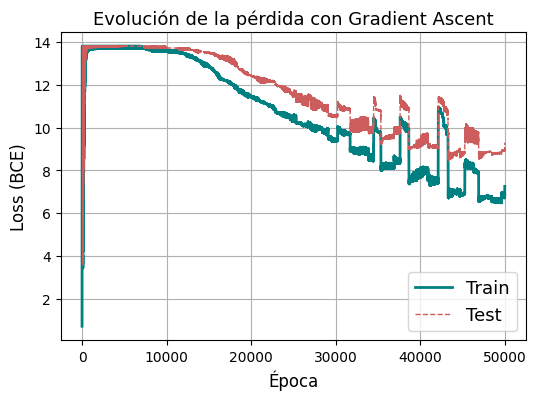

In [ ]:
plot_loss(train_loss_hist_ga, test_loss_hist_ga, title="Evolución de la pérdida con Gradient Ascent", gd=False, lw=1)

##### `EJERCICIO 4 IMPACTO DEL PARÁMETRO α EN LA CONVERGENCIA DEL MÉTODO`

In [110]:
from tqdm.auto import tqdm

best_alphas = [0.001, 0.0001]

results_alpha_sweep_ga = {}

for alpha in tqdm(best_alphas, desc="α sweep"):

    w_ga_i, b_ga_i, train_loss_hist_ga_i, train_acc_hist_ga_i, test_loss_hist_ga_i, test_acc_hist_ga_i = gradient_ascent_with_eval(
        X_train_n, y_train,
        X_test_n,  y_test,
        seed=SEED,
        alpha=alpha,
        max_epochs=30000,
        verbose=False
    )

    final_train_logloss_ga_i= train_loss_hist_ga_i[-1]
    final_test_logloss_ga_i = test_loss_hist_ga_i[-1] if test_loss_hist_ga_i else None
    final_train_acc_ga_i    = train_acc_hist_ga_i[-1]
    final_test_acc_ga_i     = test_acc_hist_ga_i[-1]  if test_acc_hist_ga_i  else None

    results_alpha_sweep_ga[alpha] = {
        'train_logloss_final': final_train_logloss_ga_i,
        'test_logloss_final':  final_test_logloss_ga_i,
        'acc_train_final':     final_train_acc_ga_i,
        'acc_test_final':      final_test_acc_ga_i,
        'loss_train':  train_loss_hist_ga_i,
        'loss_test':   test_loss_hist_ga_i,
        'acc_train':      train_acc_hist_ga_i,
        'acc_test':       test_acc_hist_ga_i,
    }

    print(f"α={alpha:.4g} → "
          f"Train LL={final_train_logloss_ga_i:.4f}, acc={final_train_acc_ga_i:.4f}  |  "
          f"Test  LL={final_test_logloss_ga_i:.4f}, acc={final_test_acc_ga_i:.4f}")



α sweep:   0%|          | 0/2 [00:00<?, ?it/s]

GA training:   0%|          | 0/30000 [00:00<?, ?it/s]

α=0.001 → Train LL=9.3729, acc=0.6526  |  Test  LL=10.6175, acc=0.6128


GA training:   0%|          | 0/30000 [00:00<?, ?it/s]

α=0.0001 → Train LL=7.7992, acc=0.6626  |  Test  LL=8.4855, acc=0.6159


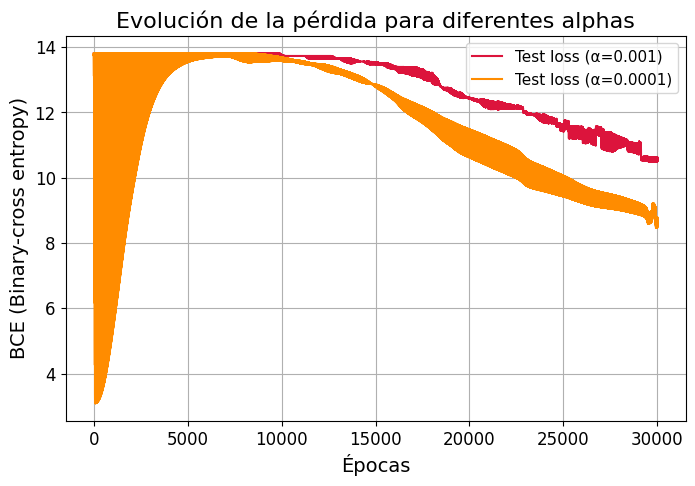

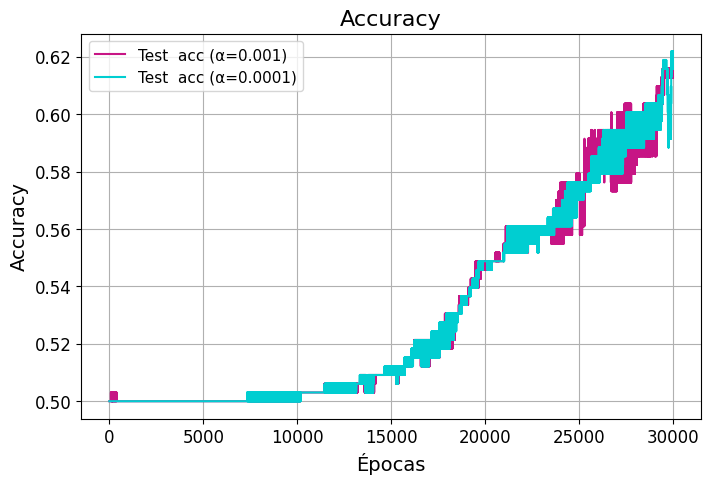

In [111]:
plot_metrics_by_alpha(results_alpha_sweep_ga, title1="Evolución de la pérdida para diferentes alphas", title2="Accuracy", gd=False)

Entrenamiento final

In [97]:
def evaluate_model_ga(X, y, w, b):
    z      = np.dot(X, w) + b
    y_pred = sigmoid(z)

    loss   = average_log_loss(w, b, X, y)

    acc    = accuracy(y, y_pred)
    return loss, acc

In [ ]:
w_final_ga, b_final_ga, train_loss_hist_final_ga, train_acc_hist_final_ga, test_loss_hist_final_ga, test_acc_hist_final_ga = gradient_ascent_with_eval(
    X_train_n, y_train,
    X_test_n,  y_test,
    seed=SEED,
    alpha=0.001,
    max_epochs=130000,
    verbose=True
)


GA training:   0%|          | 0/150000 [00:00<?, ?it/s]

Epoch    1 | Train loss=0.7102, acc=0.5000 | Test loss=13.8155, acc=0.5000
Epoch 15000 | Train loss=12.8631, acc=0.5330 | Test loss=13.4785, acc=0.5122
Epoch 30000 | Train loss=9.3729, acc=0.6526 | Test loss=10.6175, acc=0.6128
Epoch 45000 | Train loss=6.8458, acc=0.7492 | Test loss=8.8569, acc=0.6738
Epoch 60000 | Train loss=1.3166, acc=0.9502 | Test loss=4.0041, acc=0.8323
Epoch 75000 | Train loss=1.2237, acc=0.9502 | Test loss=3.6470, acc=0.8537
Epoch 90000 | Train loss=0.4523, acc=0.9755 | Test loss=3.0610, acc=0.8720
Epoch 105000 | Train loss=0.1764, acc=0.9900 | Test loss=2.8069, acc=0.8780
Epoch 120000 | Train loss=0.1012, acc=0.9954 | Test loss=2.5412, acc=0.8963
Epoch 135000 | Train loss=0.0850, acc=0.9969 | Test loss=2.5590, acc=0.9024
Epoch 150000 | Train loss=0.0491, acc=0.9969 | Test loss=2.5466, acc=0.8963


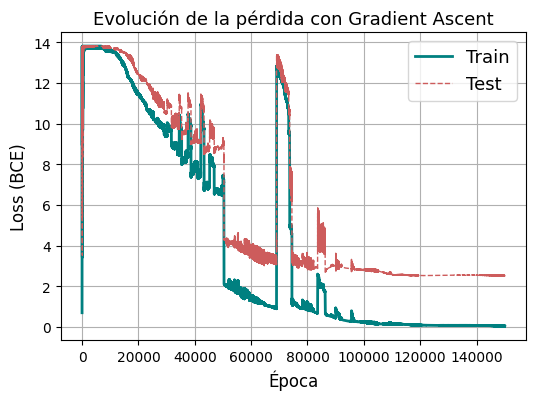

In [ ]:
plot_loss(train_loss_hist_final_ga, test_loss_hist_final_ga, title="Evolución de la pérdida con Gradient Ascent", gd=False, lw=1)

In [ ]:
bce_test_final_ga, acc_test_final_ga = evaluate_model_ga(X_test_n, y_test, w_final_ga, b_final_ga)
bce_train_final_ga, acc_train_final_ga = evaluate_model_ga(X_train_n, y_train, w_final_ga, b_final_ga)

In [ ]:
resultados_finales_ga = {}

resultados_finales_ga[alpha] = {
    'mse_test': mse_test_final_gd,
    'mse_train': mse_train_final_gd,
    'acc_train_final': acc_train_final_gd,
    'acc_test_final': acc_test_final_gd,
    'acc_train': acc_hist_train_final_gd,
    'acc_test': acc_hist_test_final_gd,
    'loss_train': loss_hist_train_final_gd,
    'loss_test': loss_hist_test_final_gd,
}

print(f"Test MSE = {mse_test_final_gd:.4f} | Acc Test = {acc_test_final_gd:.4f} | "
      f"Train MSE = {mse_train_final_gd:.4f} | Acc Train = {acc_train_final_gd:.4f}")

In [100]:
def predecir_ga(X, w, b):
    z      = np.dot(X, w) + b
    y_pred = sigmoid(z)
    return (y_pred >= 0.5).astype(int)

In [ ]:
y_pred_train_ga = predecir_ga(X_train_n, w_final_ga, b_final_ga)
cm_train_ga = confusion_matrix(y_train, y_pred_train_ga)

plot_confusion_matrix(cm_train_ga, titulo="Matriz de Confusión GA - Train")

NameError: name 'b_final_ga' is not defined

In [ ]:
y_pred_test_ga = predecir_ga(X_test_n, w_final_ga, b_final_ga)
cm_test_ga = confusion_matrix(y_test, y_pred_test_ga)

plot_confusion_matrix(cm_test_ga, titulo="Matriz de Confusión GA - Test")

##### `EJERCICIO 5 COMPARACIÓN DE RESULTADOS`

In [ ]:
from IPython.display import display, Markdown

results = {
    'GD': {
        'train_loss': mse_train_final_gd,
        'train_acc': acc_train_final_gd,
        'test_loss': mse_test_final_gd,
        'test_acc': acc_test_final_gd,
    },
    'GA': {
        'train_loss': bce_train_final_ga,
        'train_acc': acc_train_final_ga,
        'test_loss': bce_test_final_ga,
        'test_acc': acc_test_final_ga,
    }
}

table = (
    "| Método | Train Loss | Train Acc | Test Loss | Test Acc |\n"
    "|---|---|---|---|---|\n"
    f"| GD | {results['GD']['train_loss']:.4f} | {results['GD']['train_acc']:.4f} | "
    f"{results['GD']['test_loss']:.4f} | {results['GD']['test_acc']:.4f} |\n"
    f"| GA | {results['GA']['train_loss']:.4f} | {results['GA']['train_acc']:.4f} | "
    f"{results['GA']['test_loss']:.4f} | {results['GA']['test_acc']:.4f} |"
)

display(Markdown(table))